In [1]:
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras import optimizers

from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import ImageDataGenerator
from keras.utils import array_to_img, img_to_array, load_img
from keras.optimizers import SGD

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')

%matplotlib inline

C:\Users\HP\AppData\Local\Temp\ipykernel_11768\1499801117.py:22: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import tensorflow as tf
print(tf.__version__)

2.16.1


C:/Users/HP/Desktop/python/archive/img_align_celeba/img_align_celeba/000048.jpg
C:/Users/HP/Desktop/python/archive/
0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


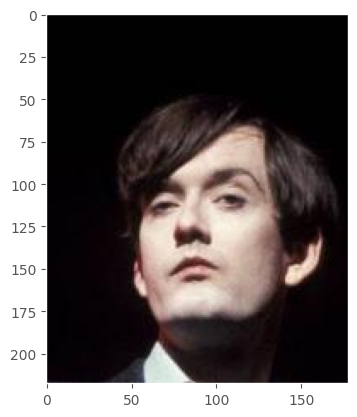

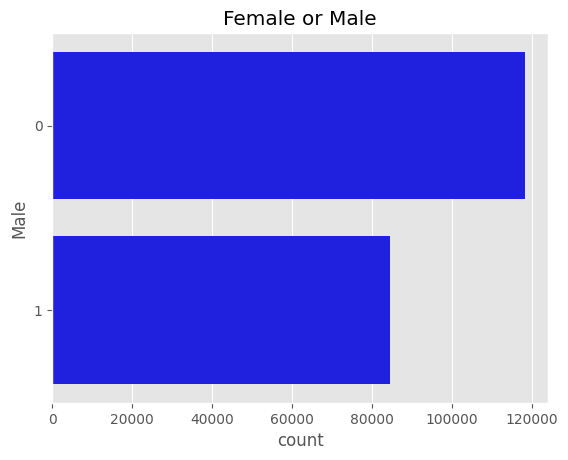

In [3]:
main_folder = 'C:/Users/HP/Desktop/python/archive/' 

images_folder = main_folder + 'img_align_celeba/img_align_celeba/'

EXAMPLE_PIC = images_folder + '000048.jpg'

print(EXAMPLE_PIC)
print(main_folder)
TRAINING_SAMPLES = 10000
VALIDATION_SAMPLES = 2000
TEST_SAMPLES = 2000
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 16
NUM_EPOCHS = 20


df_attr = pd.read_csv(main_folder + 'list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

# List of available attributes
for i, j in enumerate(df_attr.columns):
    print(i, j)




try:
  # Load the image using PIL's open function
  img = load_img(EXAMPLE_PIC)

  # Convert the image to RGB mode (if necessary)
  img = img.convert('RGB')

  # You can further process the image here (e.g., resize)

  # Display the image (optional)
  plt.grid(False)
  plt.imshow(img)
  plt.show()
except FileNotFoundError:
  print(f"Error: Image file '{EXAMPLE_PIC}' not found.")

  # Female or Male?
plt.title('Female or Male')
sns.countplot(y='Male', data=df_attr, color="b")
plt.show()


# Recomended partition
df_partition = pd.read_csv(main_folder + 'list_eval_partition.csv')
df_partition.head()

df_partition['partition'].value_counts().sort_index()

df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr['Male'], how='inner')
df_par_attr.head()

def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)
    return x

def generate_df(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test

    '''
    df_ = df_par_attr[(df_par_attr['partition'] == partition)
                           & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition)
                                  & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

    # for Train and Validation
    if partition != 2:
        x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = to_categorical(df_[attr],2)
    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(images_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])
    return x_, y_

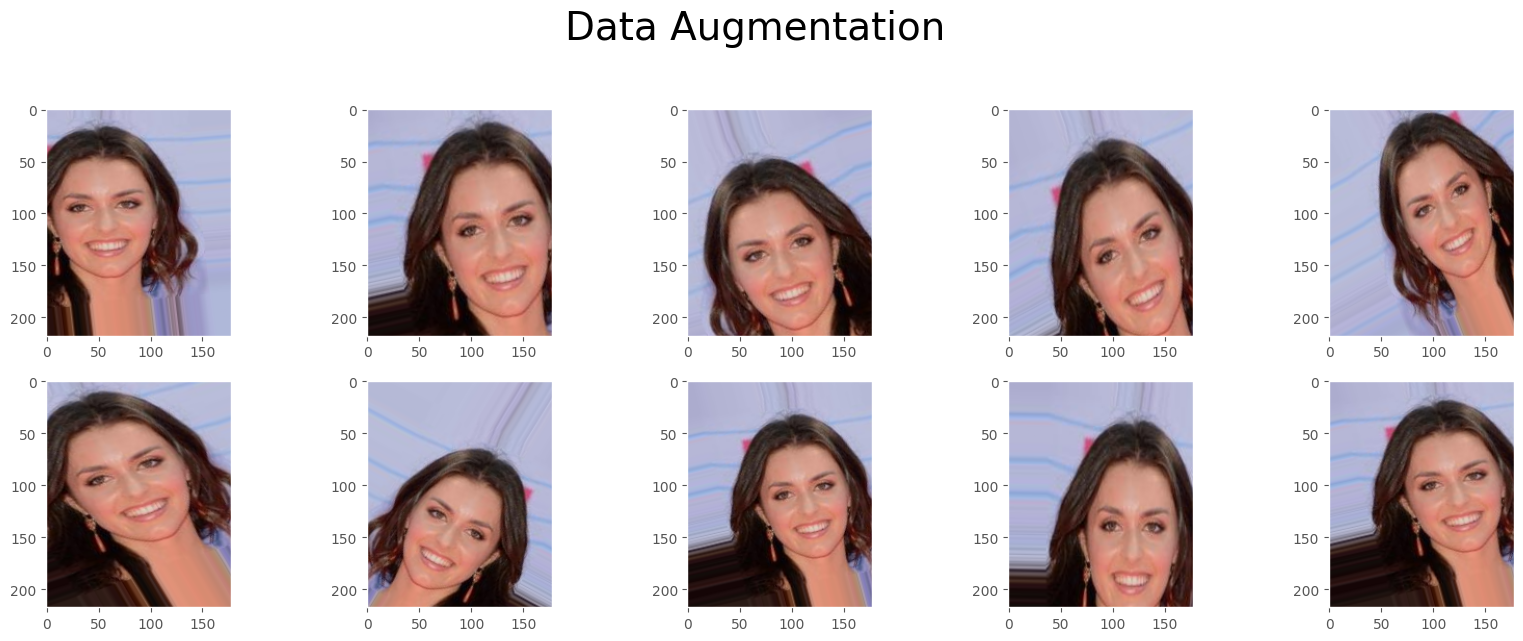

In [4]:
# Generate image generator for data augmentation
datagen =  ImageDataGenerator(
  #preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)
eg = 'C:/Users/HP/Desktop/python/archive/img_align_celeba/img_align_celeba/' + '000043.jpg'
# load one image and reshape
img = load_img(eg)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

# plot 10 augmented images of the loaded iamge
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow( batch.reshape(218, 178, 3))
    
    if i == 9:
        break
    i += 1
    
plt.show()
eg = 'C:/Users/HP/Desktop/python/archive/img_align_celeba/img_align_celeba/' + '000043.jpg'


In [5]:
from tensorflow.keras.utils import to_categorical

In [6]:
x_train, y_train = generate_df(0, 'Male', TRAINING_SAMPLES)

# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
    x_train, 
    y_train,
    batch_size=BATCH_SIZE,
)

In [7]:
x_valid, y_valid = generate_df(1, 'Male', VALIDATION_SAMPLES)

*Load the model: Inception*

In [8]:
# Import InceptionV3 Model
inc_model = InceptionV3(weights='C:/Users/HP/Desktop/python/archive/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("number of layers:", len(inc_model.layers))

number of layers: 311


In [9]:
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

In [10]:
# creating the final model 
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:52]:
    layer.trainable = False

# compile the model
model_.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

In [11]:
checkpointer = ModelCheckpoint(filepath='weights.best.inc.male.keras', 
                               verbose=1, save_best_only=True)

hist = model_.fit(train_generator
                     , validation_data = (x_valid, y_valid)
                      , steps_per_epoch= TRAINING_SAMPLES//BATCH_SIZE
                      , epochs= NUM_EPOCHS
                      , callbacks=[checkpointer]
                      , verbose=1
                    )


Epoch 1/20


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5055 - loss: 0.7222
Epoch 1: val_loss improved from inf to 6.85597, saving model to weights.best.inc.male.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 1317s 2s/step - accuracy: 0.5055 - loss: 0.7222 - val_accuracy: 0.5000 - val_loss: 6.8560
Epoch 2/20


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 6.85597
625/625 ━━━━━━━━━━━━━━━━━━━━ 69s 110ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 6.8560
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5445 - loss: 0.6934
Epoch 3: val_loss did not improve from 6.85597
625/625 ━━━━━━━━━━━━━━━━━━━━ 1030s 2s/step - accuracy: 0.5445 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 8.7870
Epoch 4/20

Epoch 4: val_loss did not improve from 6.85597
625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 90ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 8.7870
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5409 - loss: 0.6890
Epoch 5: val_loss improved from 6.85597 to 2.80102, saving model to weights.best.inc.male.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 951s 2s/step - accuracy: 0.5409 - loss: 0.6890 - val_accuracy: 0.5000 - val_loss: 2.8010
Epoch 6/20

Epoch 6: val_loss did not improve from 2.80102
625/625 ━━━━━━━━━━━━━━━━━━━━ 

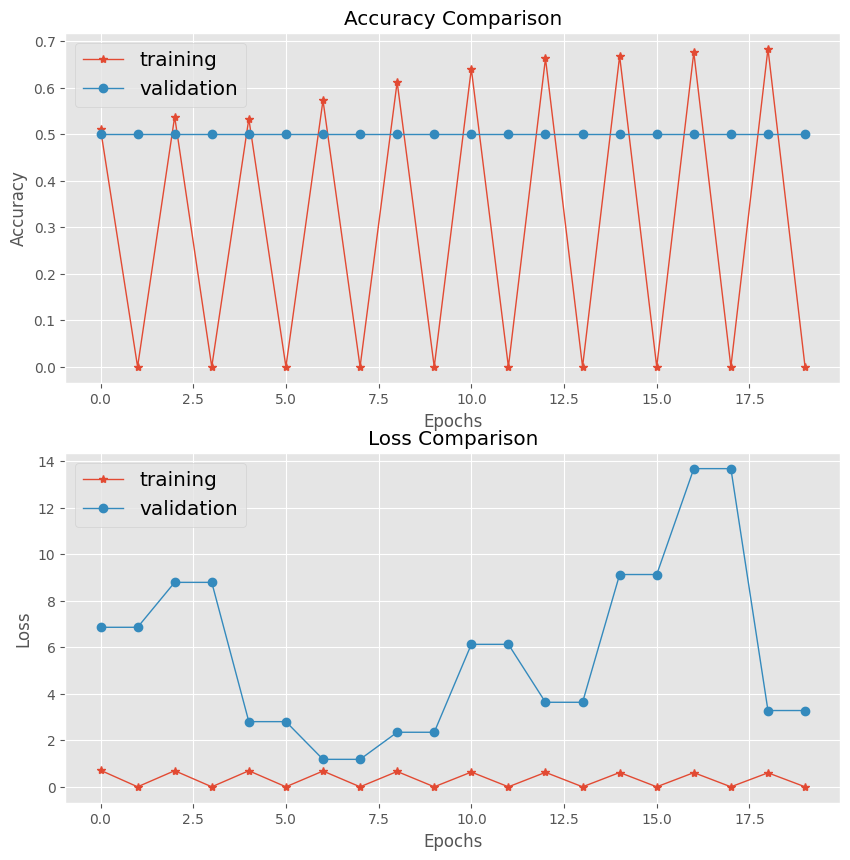

In [16]:
def visualize_training(history, lw = 1):
    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.plot(history.history['accuracy'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_accuracy'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend(fontsize = 'x-large')

    plt.subplot(2,1,2)
    plt.plot(history.history['loss'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_loss'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(fontsize = 'x-large')
    plt.grid(True)
    plt.show()


visualize_training(hist)

In [ ]:
model_.load_weights('weights.best.inc.male.keras')

In [18]:
# Test Data
x_test, y_test = generate_df(2, 'Male', TEST_SAMPLES)

# generate prediction
model_predictions = [np.argmax(model_.predict(feature)) for feature in x_test ]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test, model_predictions))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/

In [19]:
#dictionary to name the prediction
gender_target = {0: 'Female'
                , 1: 'Male'}

def img_to_display(filename):
    # inspired on this kernel:
    # https://www.kaggle.com/stassl/displaying-inline-images-in-pandas-dataframe
    # credits to stassl :)
    
    i = Image.open(filename)
    i.thumbnail((200, 200), Image.LANCZOS)
    
    with BytesIO() as buffer:
        i.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()
    

def display_result(filename, prediction, target):
    gender = 'Male'
    gender_icon = "https://png.pngtree.com/png-clipart/20190705/original/pngtree-man-avatar-icon-professional-man-character-png-image_4356027.jpg"
        
    if prediction[1] <= 0.5:
        gender_icon = "https://png.pngtree.com/png-clipart/20190614/original/pngtree-female-avatar-vector-icon-png-image_3725439.jpg"
        gender = 'Female'
            
    display_html = '''
    <div style="overflow: auto;  border: 2px solid #D8D8D8;
        padding: 5px; width: 480px;" >
        <img src="data:image/jpeg;base64,{}" style="float: left;" width="200" height="200">
        <div style="padding: 10px 0px 0px 20px; overflow: auto;">
            <img src="{}" style="float: left;" width="40" height="40">
            <h3 style="margin-left: 50px; margin-top: 2px;">Prediction: {}</h3>
            <p style="margin-left: 50px; margin-top: -6px; font-size: 12px">{} probability</p>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Real gender: {}</p>
        </div>
    </div>
    '''.format(img_to_display(filename)
               , gender_icon
               , gender
               , "{0:.2f}%".format(round(max(prediction)*100,2))
               , gender_target[target]
               , filename.split('/')[-1]
               )

    display(HTML(display_html))

In [21]:
def gender_prediction(filename):
    '''
    predict the gender
    
    input: filename: str of the file name
        
    return: array of the prob of the targets.
    
    '''
    im = cv2.imread(filename)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (178, 218)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    
    # prediction
    result = model_.predict(im)
    prediction = np.argmax(result)
    
    return result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step



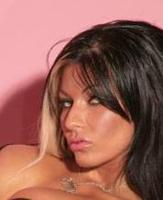

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step



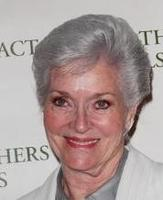

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step



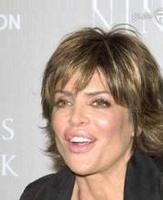

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step



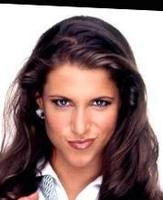

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step



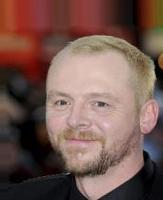

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step



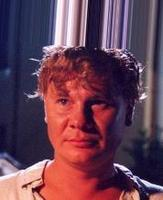

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step



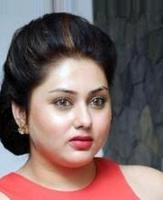

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step



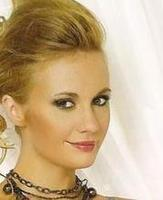

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step



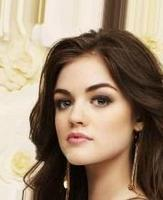

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step



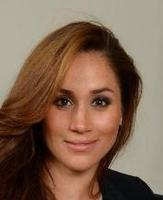

In [22]:
#select random images of the test partition
df_to_test = df_par_attr[(df_par_attr['partition'] == 2)].sample(10)

for index, target in df_to_test.iterrows():
    result = gender_prediction(images_folder + index)
    
    #display result
    display_result(images_folder + index, result[0], target['Male'])

In [28]:

# Load VGG16 without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Add custom layers for gender classification
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # Assuming binary classification: male/female

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Now you can train this model on your gender dataset
# Assuming train_generator and validation_generator are your data generators
model.fit(train_generator, validation_data=(x_valid, y_valid), epochs=10)

# Save the trained model
model.save('gender_classification_model.keras')


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1313s 2s/step - accuracy: 0.5230 - loss: 1.2780 - val_accuracy: 0.4910 - val_loss: 0.7764
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1008s 2s/step - accuracy: 0.5234 - loss: 0.7214 - val_accuracy: 0.4760 - val_loss: 0.7412
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 843s 1s/step - accuracy: 0.5266 - loss: 0.6923 - val_accuracy: 0.5005 - val_loss: 0.7664
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1219s 2s/step - accuracy: 0.5100 - loss: 0.6938 - val_accuracy: 0.4990 - val_loss: 0.7609
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3253s 5s/step - accuracy: 0.5169 - loss: 0.6922 - val_accuracy: 0.4990 - val_loss: 0.7653
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 883s 1s/step - accuracy: 0.5109 - loss: 0.6940 - val_accuracy: 0.5000 - val_loss: 0.8009
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 882s 1s/step - accuracy: 0.5200 - loss: 0.6922 - val_accuracy: 0.5005 - val_loss: 0.7800
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 856s 1s/step - accuracy: 0.5036 - loss: 0.6936 - val_

AbortedError: Graph execution error:

Detected at node StatefulPartitionedCall/functional_11_1/block3_conv2_1/Relu defined at (most recent call last):
<stack traces unavailable>
Operation received an exception:Status: 1, message: could not create a memory object, in file tensorflow/core/kernels/mkl/mkl_conv_ops.cc:1112
	 [[{{node StatefulPartitionedCall/functional_11_1/block3_conv2_1/Relu}}]] [Op:__inference_one_step_on_iterator_311705]